# Lung inflammation v3 - ResNet50

This notebook uses the [dataset](https://osf.io/28qbc/) from the publication "[Deep neural network based histological scoring of lung fibrosis and inflammation in the mouse model system](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0202708)" to train an CNN based on a ResNet50 to characterize inflammatory lung diseases from sections of lung tissue.<br><br>

**Publication benchmark:**<br>
Model: Inception V3, pretrained on ImageNet<br>
Accuracy: 0.80 (80%).<br><br>


<font color='blue'>**Notebook results:**<br>
Model: ResNet50, pretrained on ImageNet<br>
Data: training and validation data were used as in the provided dataset<br>
Training: image size of 224 for stage 1 and 2, image size of 512 for stage 3;<br>
stage 1: training of new network head;<br>
stage 2: training of the entire network with discriminative learning rates;<br>
stage 3: training of the entire network<br>
Accuracy: 0.82 (82%).<br><br>
    
**Summary:**<br>In this notebook it could be shown that state-of-the-art results published August 23 2018 could be  improved with a smaller model.

## Notebook setup

In [1]:
## notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai
from fastai import *
from fastai.vision import *

In [3]:
# set path
path = Path('/home/paperspace/fastai/data/lung'); path

PosixPath('/home/paperspace/fastai/data/lung')

## Setup data and model (stage 1 and 2)

### Data setup

In [4]:
# set batchsize and image size for network
bs = 32
size = 224

In [5]:
# different transformations (the increase of the max_rotate parameter is crucial to improve the performance)
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0, max_warp=0.2) #1
#tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=1.1, max_lighting=0.1, max_warp=0.2) #2
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=1.1, max_lighting=0.1, max_warp=0.2) #3

In [6]:
# setup data with fastai data block API (https://docs.fast.ai/data_block.html)
data = (ImageFileList.from_folder(path/'lung_inflammation', extensions='.png')\
        .label_from_folder() # get labels from folders\
        .split_by_folder() # split dataset by train/valid folders\
        .datasets(ImageClassificationDataset) # creat image classification dataset\
        .transform(tfms, size=size) # apply transformations and resize images\
        .databunch(bs=bs)) # creat databunch with bs

In [7]:
# normaliez data with ImagNet statistics
data.normalize(imagenet_stats);

In [8]:
# print class names, number of class, length of train dataset, and length of valid dataset
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '2', '3', 'ignore', '1'], 5, 3974, 726)

### Model setup

A ResNet34 is setup with pretrained weights from Imagenet with a custom head, i.e. the final layers specific for ImageNet classification are removed and replaced by final layers suitable for our 5 classes.

In [9]:
!gpustat

psbtmxtmo  Fri Nov  2 08:40:38 2018
[0] Quadro P4000     | 40'C,   0 % |  1357 /  8119 MB | paperspace(1347M)


In [10]:
# set dropout
ps = 0.5 # default 0.5

In [11]:
learn = create_cnn(data, models.resnet50, metrics=accuracy, ps=ps)

In [13]:
!gpustat

psbtmxtmo  Fri Nov  2 08:41:04 2018
[0] Quadro P4000     | 44'C,  42 % |  1940 /  8119 MB | paperspace(1347M) paperspace(583M)


## Training (stage 1 and 2)

### Stage 1 - Training of new head

In stage 1 only the new head of the network is trained and rest is frozen.

In [14]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


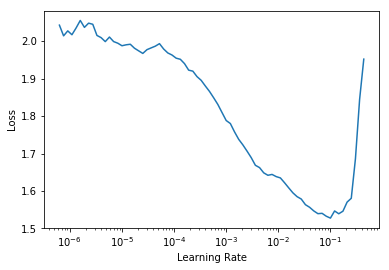

In [15]:
learn.recorder.plot()

In [16]:
lr = 5e-3

In [17]:
learn.fit_one_cycle(12, max_lr=lr)

Total time: 09:48
epoch  train_loss  valid_loss  accuracy
1      1.035843    0.787837    0.691460  (01:02)
2      0.831251    0.671410    0.739669  (00:53)
3      0.753446    0.635666    0.741047  (00:51)
4      0.718693    0.585086    0.772727  (00:53)
5      0.713682    0.619162    0.757576  (00:50)
6      0.668116    0.542445    0.792011  (00:51)
7      0.638452    0.603531    0.763085  (00:53)
8      0.590764    0.513048    0.804408  (00:48)
9      0.616871    0.513183    0.803030  (00:40)
10     0.556828    0.488188    0.811295  (00:38)
11     0.520218    0.464402    0.826446  (00:35)
12     0.508246    0.484255    0.820937  (00:50)



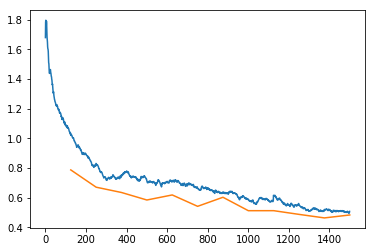

In [18]:
learn.recorder.plot_losses()

In [19]:
learn.save('lung_inf_v2-ResNet50_stage-1_20181102-1')

<font color=blue>**Conclusion stage 1 - Training of new head:**<br>
Training only the the new last layers from the new head (and keeping the rest of the network frozen) enabled the network to achieve a accuracy of approx. 0.82 (82%) after 12 epochs. This is already slightly higher than the published accuracy benchmark!

### Stage 2 - Training of the entire network

In stage 2 the entire network is trained with discriminative learning rates, i.e. lower learning rates for the earyl layers and higher learning rates for the late layers.

In [21]:
learn.load('lung_inf_v2-ResNet50_stage-1_20181102-1')

In [22]:
learn.unfreeze()

In [23]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


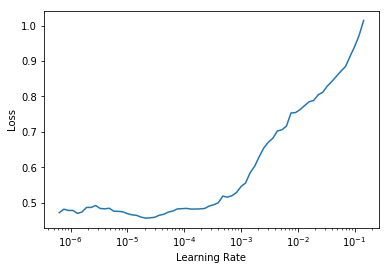

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, lr/10))

Total time: 00:46
epoch  train_loss  valid_loss  accuracy
1      0.500309    0.483465    0.823691  (00:46)



In [26]:
learn.fit_one_cycle(10, max_lr=slice(1e-6, lr/10))

Total time: 07:43
epoch  train_loss  valid_loss  accuracy
1      0.542053    0.464734    0.822314  (00:45)
2      0.503519    0.474761    0.825069  (00:46)
3      0.523548    0.456522    0.818182  (00:46)
4      0.494897    0.457953    0.833333  (00:46)
5      0.503483    0.466491    0.823691  (00:46)
6      0.494309    0.476941    0.820937  (00:46)
7      0.504780    0.458843    0.830579  (00:46)
8      0.484040    0.469063    0.829201  (00:46)
9      0.466178    0.467449    0.819559  (00:46)
10     0.429545    0.463032    0.830579  (00:46)



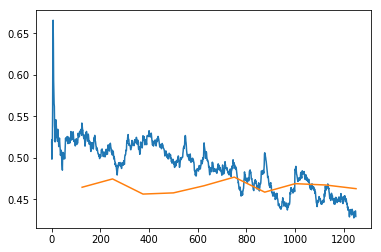

In [27]:
learn.recorder.plot_losses()

In [28]:
learn.save('lung_inf_v2-ResNet50_stage-2_20181102-1')

In [29]:
learn.load('lung_inf_v2-ResNet50_stage-2_20181102-1')

<font color=blue>**Conclusion stage 2 - Training of the entire network:**<br>
The training of the entire network with discriminative learning rates reduced the training loss and increased the accuracy slightly.

## Setup data and model (stage 3)

In [30]:
# set batchsize and image size for network
bs = 32//4 # floor divided by 4 to make up for the image increas of approx. 4x more pixels
size = 512

In [31]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_zoom=1.1, max_lighting=0.1, max_warp=0.2)

In [32]:
# setup data with fastai data block API (https://docs.fast.ai/data_block.html)
data = (ImageFileList.from_folder(path/'lung_inflammation', extensions='.png')\
        .label_from_folder() # get labels from folders\
        .split_by_folder() # split dataset by train/valid folders\
        .datasets(ImageClassificationDataset) # creat image classification dataset\
        .transform(tfms, size=size) # apply transformations and resize images\
        .databunch(bs=bs)) # creat databunch with bs

In [33]:
# normaliez data with ImagNet statistics
data.normalize(imagenet_stats);

### Model setup

In [34]:
!gpustat

psbtmxtmo  Fri Nov  2 09:09:16 2018
[0] Quadro P4000     | 44'C,   0 % |  4173 /  8119 MB | paperspace(4163M)


In [35]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

In [36]:
learn.load('lung_inf_v2-ResNet50_stage-2_20181102-1')

In [37]:
learn.unfreeze()

In [38]:
!gpustat

psbtmxtmo  Fri Nov  2 09:09:59 2018
[0] Quadro P4000     | 42'C,   0 % |  4173 /  8119 MB | paperspace(4163M)


## Training (stage 3)

### Stage 3 - Increased image size

In [39]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


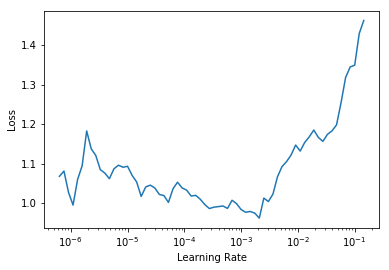

In [40]:
learn.recorder.plot()

In [41]:
lr = 1e-4

In [42]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 10:52
epoch  train_loss  valid_loss  accuracy
1      0.833015    0.675197    0.719008  (03:40)
2      0.741371    0.497659    0.804408  (03:35)
3      0.640973    0.496683    0.811295  (03:35)



In [43]:
learn.save('lung_inf_v2-ResNet50_stage-3_20181102-1a')

In [45]:
learn.load('lung_inf_v2-ResNet50_stage-3_20181102-1a')

In [46]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 10:46
epoch  train_loss  valid_loss  accuracy
1      0.738194    0.580400    0.790634  (03:35)
2      0.686307    0.499762    0.807163  (03:35)
3      0.602276    0.488374    0.815427  (03:35)



In [47]:
learn.save('lung_inf_v2-ResNet50_stage-3_20181102-1b')

In [48]:
learn.load('lung_inf_v2-ResNet50_stage-3_20181102-1b')

In [49]:
learn.fit_one_cycle(10, max_lr=lr)

Total time: 35:57
epoch  train_loss  valid_loss  accuracy
1      0.659038    0.506834    0.805785  (03:35)
2      0.771952    0.563429    0.794766  (03:35)
3      0.802874    0.624147    0.754821  (03:36)
4      0.675051    0.541264    0.800275  (03:35)
5      0.709671    0.549454    0.805785  (03:35)
6      0.633758    0.553013    0.779614  (03:35)
7      0.592638    0.523042    0.794766  (03:35)
8      0.617851    0.523454    0.798898  (03:35)
9      0.564420    0.485249    0.808540  (03:35)
10     0.555589    0.506931    0.796143  (03:36)



In [50]:
learn.save('lung_inf_v2-ResNet50_stage-3_20181102-1c')

In [51]:
learn.load('lung_inf_v2-ResNet50_stage-3_20181102-1c')

In [52]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 10:44
epoch  train_loss  valid_loss  accuracy
1      0.685552    0.646375    0.731405  (03:33)
2      0.615075    0.490617    0.812672  (03:35)
3      0.597613    0.509807    0.807163  (03:35)



In [53]:
learn.save('lung_inf_v2-ResNet50_stage-3_20181102-1d')

In [54]:
learn.load('lung_inf_v2-ResNet50_stage-3_20181102-1d')

In [55]:
learn.fit_one_cycle(3, max_lr=lr)

Total time: 10:50
epoch  train_loss  valid_loss  accuracy
1      0.614899    0.513265    0.803030  (03:35)
2      0.625649    0.517048    0.789256  (03:37)
3      0.544867    0.500501    0.809917  (03:37)



In [56]:
learn.save('lung_inf_v2-ResNet50_stage-3_20181102-1e')

In [57]:
learn.load('lung_inf_v2-ResNet50_stage-3_20181102-1e')

## Interpretation

In [58]:
interp = ClassificationInterpretation.from_learner(learn)

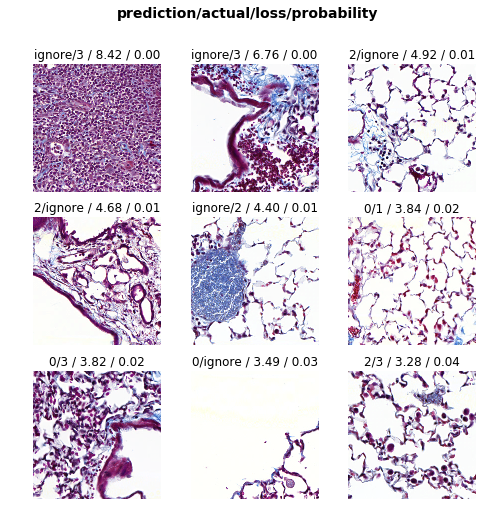

In [59]:
interp.plot_top_losses(9, figsize=(8,8))

In [60]:
interp.confusion_matrix()

array([[229,   1,   0,  11,  35],
       [  1,  49,   3,   2,  20],
       [  1,  14,  53,   2,   0],
       [  8,   2,   2, 182,   2],
       [ 14,  18,   1,   1,  75]])

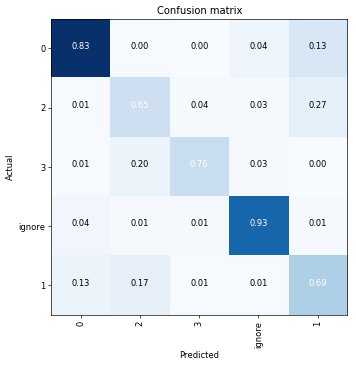

In [61]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60, normalize=True)